<a href="https://colab.research.google.com/github/ArbivIdan/CarAccident/blob/MoveCommonStringsToConstatns/notebook868fa996da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPool2D, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# read me
# Access the uploaded folder
import os
os.chdir('/content/drive/MyDrive/CarAccidentData/data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setting up our Data  
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

In [ ]:
batch_size = 100
img_height = 112
img_width = 112

The dataset that we are using has 3 different folders, and each of these have 2 folders within them having a folder for accident images and non accident images. Do look and scroll through them to verify and see the structure.  
In order to get our:  
1. train,
2. test
3. and validation split,  

we will use keras's inbuilt *image_dataset_from_directory()* function which is able to generate a tf dataset containing the images as well as their corresponding classes from the folder that we pass into the parameter.

In [ ]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CarAccidentData/data/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CarAccidentData/data/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/CarAccidentData/data/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

def preprocess_image(image, label):
    # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # Normalize pixel values to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

training_ds = training_ds.map(preprocess_image)
testing_ds = testing_ds.map(preprocess_image)
validation_ds = validation_ds.map(preprocess_image)

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


In [ ]:
input_shape = (112, 112, 1)


# Define model architecture
inputs = Input(shape=input_shape)
x = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(units=16, activation='relu')(x)
outputs = Dense(units=2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

# Print model summary to check number of parameters
model.summary()




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 8)       80        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 53, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 10816)             0   

Notice how we set trainable to false in order to make sure model won’t make any changes to the weights of any layers that are already frozen during training.  
We also exclude the top of the model since we will perform classification on our own.

# Creating Final Model  
We now go ahead and create our final model which consists of the base model, and 3 more layers for performing convolution. The 2d output of the convolution layer is flattened and fed to a dense output layer to perform the classification. 

In [ ]:
# model = tf.keras.Sequential([
#     base_model,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.Conv2D(128, 3, activation='relu'),
#     layers.Flatten(),
#     layers.Dense(len(class_names), activation= 'softmax')
# ])

In [ ]:
# Convert target labels to one-hot encoded format
training_ds = training_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
testing_ds = testing_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
validation_ds = validation_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))


In [ ]:


# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(training_ds, validation_data=validation_ds, epochs=10)



Epoch 1/10
8/8 [==============================] - 6s 111ms/step - loss: 0.7058 - accuracy: 0.5133 - val_loss: 0.6794 - val_accuracy: 0.4796
Epoch 2/10
8/8 [==============================] - 6s 96ms/step - loss: 0.6625 - accuracy: 0.6157 - val_loss: 0.6397 - val_accuracy: 0.6735
Epoch 3/10
8/8 [==============================] - 5s 119ms/step - loss: 0.6341 - accuracy: 0.6561 - val_loss: 0.6056 - val_accuracy: 0.6327
Epoch 4/10
8/8 [==============================] - 6s 213ms/step - loss: 0.6085 - accuracy: 0.6764 - val_loss: 0.5784 - val_accuracy: 0.7143
Epoch 5/10
8/8 [==============================] - 4s 92ms/step - loss: 0.5755 - accuracy: 0.7042 - val_loss: 0.5649 - val_accuracy: 0.7143
Epoch 6/10
8/8 [==============================] - 6s 95ms/step - loss: 0.5618 - accuracy: 0.7054 - val_loss: 0.5477 - val_accuracy: 0.6837
Epoch 7/10
8/8 [==============================] - 4s 96ms/step - loss: 0.5259 - accuracy: 0.7358 - val_loss: 0.5244 - val_accuracy: 0.7551
Epoch 8/10
8/8 [========

We'll let our model run for 50 epochs, which seems like a decent enough number. Increasing the epochs should result in an increase in accuracy uptil a certain point only though...

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(testing_ds)

1/1 [==============================] - 1s 975ms/step - loss: 0.5498 - accuracy: 0.6900


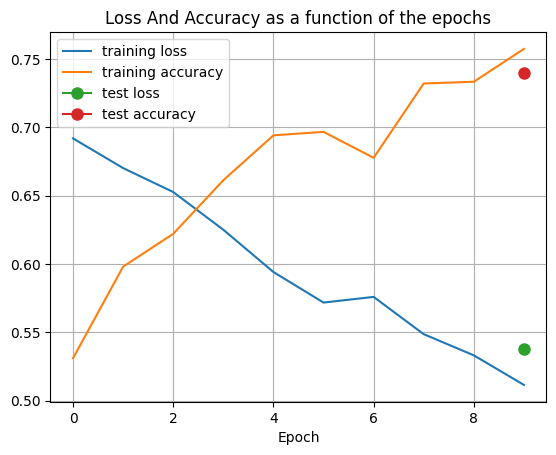

In [ ]:

plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(len(history.history['loss'])-1, test_loss, marker='o', markersize=8, label='test loss')
plt.plot(len(history.history['accuracy'])-1, test_acc, marker='o', markersize=8, label='test accuracy')
plt.grid(True)
plt.xlabel("Epoch")
plt.title("Loss And Accuracy as a function of the epochs")
plt.legend()

In [ ]:
plt.axhline(y=mean_train_loss, linestyle='--', color='red', label='mean training loss')
plt.axhline(y=mean_train_acc, linestyle='--', color='green', label='mean training accuracy')
def get_model_size(num_params):
    model_size_bytes = num_params
    model_size_kb = model_size_bytes / 1024
    model_size_mb = model_size_kb / 1024

    return {
        'bytes': f'{model_size_bytes} bytes',
        'kilobytes': f'{model_size_kb:.2f} KB',
        'megabytes': f'{model_size_mb:.2f} MB'
    }

# Print the number of parameters and the model size
num_params = model.count_params()
model_size = get_model_size(num_params)

model.summary()

print(f'Total number of parameters: {num_params}')
print(f'Model size: {model_size}')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 110, 110, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0     

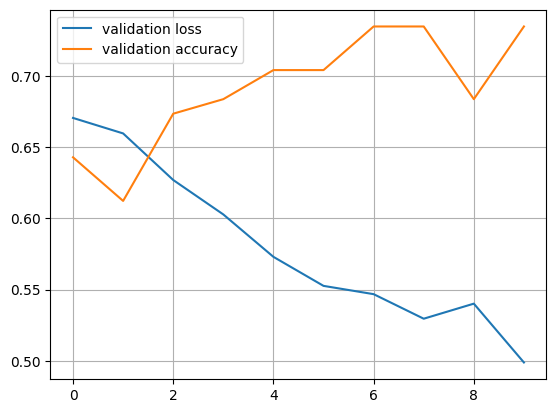

In [ ]:
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

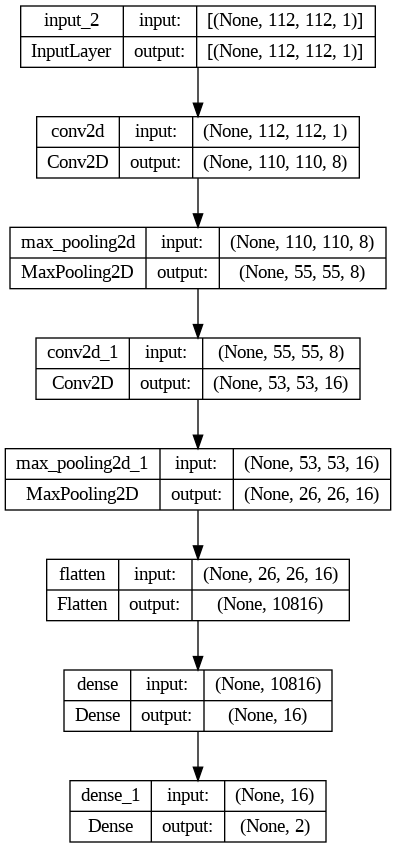

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Converting to TFLite Model  
While we've made our model, it is true that Tensor Flow models are very large and bulky and not suitable for the small processing powers that a CCTV surveillance system will handle. For this purpose, we'll convert our Tf model into a TFLite model through the API's available by keras.

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('tf_lite_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path = 'tf_lite_model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 112 112   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


While the steps below aren't necessary, I'll still show you incase you have to perform a similair task for a different model where the input tensor might change or be different.

In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 112, 112,1))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 2))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 112 112   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


# Trying Our TFLite Model Out  
We'll try our TFLite model on a random image and see what our output is and if it works. 

In [ ]:
from PIL import Image
im=Image.open("/content/drive/MyDrive/CarAccidentData/data/train/Non Accident/5_17.jpg").resize((112,112))
im= im.convert('L')
img_array = tf.keras.utils.img_to_array(im)
img_batch = np.expand_dims(img_array, axis=0)

The below lines are equivalent to performing a prediction in a TF model. *interpretor.get_tensor(*) performs the prediction.

Prediction results: Non Accident
AxesImage(size=(112, 112))


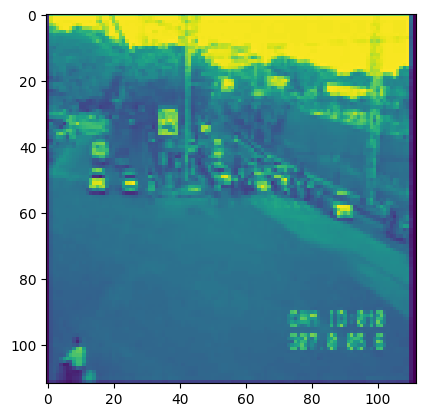

In [ ]:
interpreter.set_tensor(input_details[0]['index'], img_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results:", ["Non Accident","Accident"][np.argmax(tflite_model_predictions)])
print(plt.imshow(im))

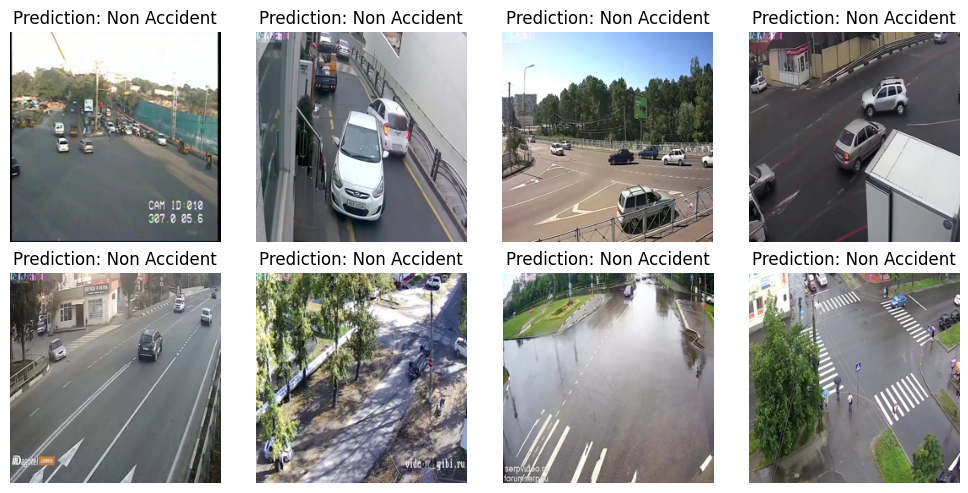

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
images = ["5_10" , "test10_2", "test11_10", "test3_22", "test4_17", "test16_3", "test17_1", "test20_1"]
prediction = ["Non Accident"]
for i, ax in enumerate(axs.flat):
    filename = f"/content/drive/MyDrive/CarAccidentData/data/train/Non Accident/{images[i]}.jpg"
    im = Image.open(filename).resize((250, 250))
    ax.imshow(im)
    ax.set_title(f"Prediction: {prediction[0]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

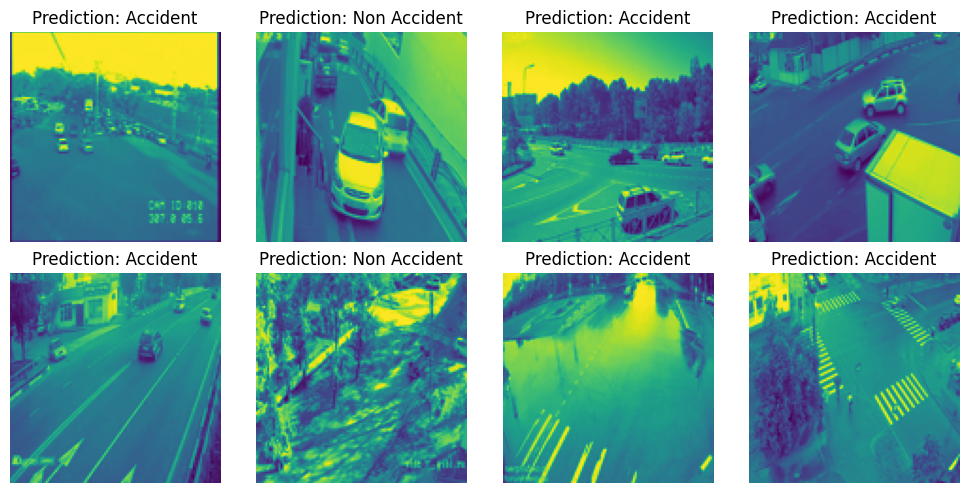

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
images = ["5_10" , "test10_2", "test11_10", "test3_22", "test4_17", "test16_3", "test17_1", "test20_1"]
prediction = ["Non Accident"]
for i, ax in enumerate(axs.flat):
    filename = f"/content/drive/MyDrive/CarAccidentData/data/train/Non Accident/{images[i]}.jpg"
    im = Image.open(filename).resize((112, 112))
    im = im.convert('L')
    img_array = tf.keras.utils.img_to_array(im)
    img_batch = np.expand_dims(img_array, axis=0)
    interpreter.set_tensor(input_details[0]['index'], img_batch)
    interpreter.invoke()
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    ax.imshow(im)
    ax.set_title(f"Prediction: " + ["Non Accident","Accident"][np.argmax(tflite_model_predictions)])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("car_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Indicate that we want to perform the default optimizations,
# which includes quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
# def representative_dataset_generator():
#   for value in x_test:
#     # Each scalar value must be inside of a 2D array that is wrapped in a list
#     yield [np.array(value, dtype=np.float32, ndmin=2)]
# converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("car_accident_model_quantized.tflite", "wb").write(tflite_model)

178336

It works. We've got a complete end to end system for accident detection now that should work very well indeed.

In [ ]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 700672 bytes
Quantized model is 178336 bytes
Difference is 522336 bytes


In [ ]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i car_accident_quantized.tflite > car_accident_model_quantized.cc
# Print the source file
!cat sine_model_quantized.cc

unsigned char sine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x80, 0x00, 0x00, 0x00, 0xd8, 0x00, 0x00, 0x00, 0x10, 0xad, 0x02, 0x00,
  0x20, 0xad, 0x02, 0x00, 0xf8, 0xb7, 0x02, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0xe2, 0x51, 0xfd, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x38, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x9c, 0xff, 0xff, 0xff, 0x11, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x31, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xc6, 0x52, 0xfd, 0xff, 0x04, 0x00, 0x00, 0x00, 0x07, 0x00, 0x